In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# ! /opt/bin/nvidia-smi
import pandas as pd
import numpy as np
import tensorflow as tf
import copy
import random
import matplotlib
from matplotlib import pyplot as plt
from time import *
import _pickle as pickle
import json
from sklearn import preprocessing
%matplotlib inline


batch_size = 128
conv1d_length = 17280


In [6]:
content = pd.read_csv(r'D:\ai price predict/dataframe.csv')
use_column = ['c', 'cap', 'h-l/c', 'ma15min', 'ma30min', 'ma1h',
              'ma2h', 'ma5h', 'ma12h', 'ma24h', 'ma48h', 'cap-ma15min', 'cap-ma30min',
              'cap-ma1h', 'cap-ma2h', 'cap-ma5h', 'cap-ma12h',
              'cap-ma24h', 'cap-ma48h',
              'usdt_huobi', 'out_4h_close']
content = content[use_column]
content = content.dropna(axis=0)
content

,c,cap,h-l/c,ma15min,ma30min,ma1h,ma2h,ma5h,ma12h,ma24h,...,cap-ma15min,cap-ma30min,cap-ma1h,cap-ma2h,cap-ma5h,cap-ma12h,cap-ma24h,cap-ma48h,usdt_huobi,out_4h_close
2879,-0.015154,-1.548159,-0.743671,-1.572242,-1.568178,-1.637321,-1.786382,-1.263505,-1.131188,-1.052054,...,0.018605,0.034100,0.023332,-0.006684,0.286852,0.479443,0.640294,0.608118,-0.000008,-0.008181
2880,0.013655,-1.542586,-0.743671,-1.577350,-1.575747,-1.634577,-1.788909,-1.268860,-1.132761,-1.053325,...,0.013835,0.028439,0.022110,-0.009583,0.280138,0.474244,0.634572,0.602998,1.380916,-0.008350
2881,-0.000750,-1.449037,-0.743671,-1.569807,-1.579504,-1.629463,-1.791714,-1.273813,-1.134626,-1.054276,...,-0.025118,-0.013651,-0.014384,-0.045355,0.225266,0.409681,0.561662,0.532670,-0.000008,-0.008319
2882,0.042465,-1.429830,-0.743671,-1.565860,-1.582578,-1.628339,-1.794454,-1.278993,-1.136875,-1.055195,...,-0.032171,-0.023169,-0.021879,-0.053329,0.211490,0.394875,0.545955,0.517647,-1.726163,-0.008365
2883,0.042463,-1.458783,-0.743671,-1.563496,-1.583531,-1.627801,-1.797458,-1.284669,-1.139215,-1.056379,...,-0.018051,-0.011038,-0.009763,-0.043460,0.223843,0.412282,0.566915,0.538390,-0.000008,-0.008441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603460,0.177807,0.435056,-0.586085,0.097981,-0.116497,-0.025860,-0.133475,-0.078250,-0.182774,0.012397,...,2.470701,-3.194530,-3.052127,-2.762415,-2.866468,-2.378572,2.755657,2.709441,-0.000008,0.001810
603461,0.165022,0.593188,-0.477721,0.168375,-0.083359,-0.012452,-0.125911,-0.073647,-0.182329,0.013017,...,1.819833,-3.204769,-3.052127,-2.927486,-2.866468,-2.819654,2.755657,2.709441,-0.000008,0.001633
603462,0.120369,0.372120,-0.636411,0.207505,-0.066028,-0.007867,-0.117966,-0.071012,-0.181810,0.013514,...,0.592416,-3.204769,-3.052127,-2.692294,-2.866468,-2.124289,2.755657,2.709441,-0.000008,0.001504
603463,-0.000750,0.131459,-0.742554,0.215807,-0.050976,-0.003416,-0.109828,-0.070424,-0.182232,0.013691,...,-0.247878,-2.404307,-3.052127,-1.384916,-1.883684,-1.113882,2.755657,1.106667,-0.345239,0.001504


In [7]:
assert list(content.columns) == use_column, 'use_column的column的列的排序不对'

In [8]:
X = np.array(content)[:, :-1]
Y = np.array(content)[:, -1]
X = preprocessing.scale(X)
Y = preprocessing.scale(Y)

mean = np.mean(Y)
std = np.std(Y)
print(f'Y mean: {mean},\nY std: {std}')
Y = (Y - mean) / std

Y mean: -2.839397797857826e-18,
Y std: 1.0000000000000002


In [9]:
class CIFAR10Sequence(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, conv1d_length, batch_size, is_train_set=True, validation_split=0.1, seed=1):
        assert len(x_set) == len(y_set), 'y 不需要进行最后的conv1d的卷积长度的去除'
        self.x, self.y = x_set, y_set[conv1d_length - 1:]
        self.conv1d_length = conv1d_length
        self.batch_size = batch_size
        item_list = [i for i in range(len(self.x) - self.conv1d_length + 1)]
        random.seed(seed)
        self.train_item_list = sorted(random.sample(item_list, int(len(item_list) * (1 - validation_split))))
        if is_train_set:
            self.item_list = self.train_item_list
        else:
            train_item_set = set(self.train_item_list)
            self.test_item_list = [i for i in item_list if i not in train_item_set]
            self.item_list = self.test_item_list

    def __len__(self):
        return len(self.item_list) // self.batch_size

    def __getitem__(self, idx):
        batch_x = [self.x[item_number: item_number + self.conv1d_length] for item_number in self.item_list[idx * self.batch_size: (idx + 1) * self.batch_size]]
        batch_y = [self.y[item_number] for item_number in self.item_list[idx * self.batch_size: (idx + 1) * self.batch_size]]

        return np.array(batch_x), np.array(batch_y)


In [10]:
train = CIFAR10Sequence(X, Y, conv1d_length, batch_size, is_train_set=True)
test = CIFAR10Sequence(X, Y, conv1d_length, batch_size, is_train_set=False)

In [20]:
len(train) * batch_size 

524928

In [21]:
len(test) * batch_size 

58240

In [11]:
train[0]

(array([[[-1.50961957e-02, -1.79250332e+00, -7.45368488e-01, ...,
           6.65785825e-01,  6.43788960e-01, -1.43787411e-05],
         [ 1.36448477e-02, -1.78692741e+00, -7.45368488e-01, ...,
           6.60016284e-01,  6.38583662e-01,  1.38169292e+00],
         [-7.25784478e-04, -1.69333385e+00, -7.45368488e-01, ...,
           5.86498463e-01,  5.67084713e-01, -1.43787411e-05],
         ...,
         [-1.39195147e+00,  2.38972174e-01, -2.22064252e-01, ...,
          -1.78545824e+00,  5.35496393e-01, -2.76342897e+00],
         [-1.29590591e+00,  3.61224489e-03,  3.81986562e-01, ...,
          -1.17455297e+00,  1.81076012e-02,  1.38169292e+00],
         [-2.85014623e+00, -2.57544172e-01,  2.86663018e+00, ...,
          -4.99634059e-01, -5.56035817e-01, -2.41800215e+00]],
 
        [[ 1.36448477e-02, -1.78692741e+00, -7.45368488e-01, ...,
           6.60016284e-01,  6.38583662e-01,  1.38169292e+00],
         [-7.25784478e-04, -1.69333385e+00, -7.45368488e-01, ...,
           5.86498463

In [13]:
train[0][0].shape

(128, 17280, 20)

In [14]:
train[0][1].shape

(128,)

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', input_shape=(conv1d_length,20)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 17278, 32)         1952      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17276, 32)         3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8638, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8636, 64)          6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8634, 64)          12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4317, 64)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 4315, 128)         2

In [0]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001), # tf.keras.optimizers.SGD(0.01)
              loss=tf.keras.losses.MSE,
              metrics = ["mean_squared_error"])

In [10]:
epochs = 55
devide = 10
print(f'epochs: {epochs}, \ndevide: {devide}')
H = model.fit_generator(train, steps_per_epoch=len(train) / devide, epochs=epochs, validation_data=test, validation_steps=len(test) / devide)  # len(train)

epochs: 55, 
devide: 10
Epoch 1/55
411/410 [==============================] - 133s 325ms/step - loss: 1.1526 - mean_squared_error: 1.1526 - val_loss: 2.0631 - val_mean_squared_error: 2.0406
Epoch 2/55
411/410 [==============================] - 126s 307ms/step - loss: 0.8480 - mean_squared_error: 0.8480 - val_loss: 2.0586 - val_mean_squared_error: 2.0362
Epoch 3/55
411/410 [==============================] - 126s 306ms/step - loss: 1.2006 - mean_squared_error: 1.2006 - val_loss: 2.0607 - val_mean_squared_error: 2.0383
Epoch 4/55
411/410 [==============================] - 126s 306ms/step - loss: 0.7594 - mean_squared_error: 0.7594 - val_loss: 2.0571 - val_mean_squared_error: 2.0347
Epoch 5/55
411/410 [==============================] - 126s 307ms/step - loss: 0.9600 - mean_squared_error: 0.9600 - val_loss: 2.0594 - val_mean_squared_error: 2.0370
Epoch 6/55
411/410 [==============================] - 126s 306ms/step - loss: 1.0506 - mean_squared_error: 1.0506 - val_loss: 2.0606 - val_mean_sq

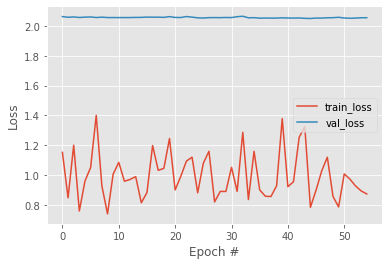

In [12]:
from_epoch = 0
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N[from_epoch:], H.history["loss"][from_epoch:], label="train_loss")
plt.plot(N[from_epoch:], H.history["val_loss"][from_epoch:], label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()